# Projet Apprentissage Automatique Supervisé
Réalisé par BISAGA Nicolas et VALENTE Hugo en L3 Info, UFR MIM Metz.

In [123]:
# librairies et versions
# Pandas version : 2.3.3
# Matplotlib version : 3.10.7
# Seaborn version : 0.13.2
# Scikit-learn version : 1.7.2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

print("Bibliothèques importées avec succès.")


Bibliothèques importées avec succès.


## Étape 1 : Choix et compréhension du dataset
### 1. Création du dataset à partir des 4 fichiers csv de 2019

In [124]:

# Chargement des fichiers
carac = pd.read_csv("caracteristiques-2019.csv", sep=";", low_memory=False)
lieux = pd.read_csv("lieux-2019.csv", sep=";", low_memory=False)
vehicules = pd.read_csv("vehicules-2019.csv", sep=";", low_memory=False)
usagers = pd.read_csv("usagers-2019.csv", sep=";", low_memory=False)

# Fusion des tables
# Fusion caractéristiques + lieux
df = carac.merge(lieux, on="Num_Acc", how="left")

# Fusion avec véhicules
df = df.merge(vehicules, on="Num_Acc", how="left")

# Fusion avec usagers
df = df.merge(usagers, on="Num_Acc", how="left")

# Résultat final
print("Dataset final :", df.shape)
df.head()

Dataset final : (253488, 56)


,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,...,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
0,201900000001,30,11,2019,01:30,4,93,93053,1,1,...,4,2,2002,0,1,0,-1,-1,-1,-1
1,201900000001,30,11,2019,01:30,4,93,93053,1,1,...,4,2,1993,5,1,0,-1,-1,-1,-1
2,201900000001,30,11,2019,01:30,4,93,93053,1,1,...,1,1,1959,0,1,0,-1,-1,-1,-1
3,201900000001,30,11,2019,01:30,4,93,93053,1,1,...,4,2,2002,0,1,0,-1,-1,-1,-1
4,201900000001,30,11,2019,01:30,4,93,93053,1,1,...,4,2,1993,5,1,0,-1,-1,-1,-1


### 2. Présentation brève du jeu de données (origine, variables, taille, objectif)
Origine : Le jeu de données df est issu de la fusion de quatre fichiers CSV sur les accidents de la route en 2019 (caractéristiques, lieux, véhicules et usagers). Ces données proviennent du site web data.gouv.fr.

Variables : Il combine des informations sur les accidents (date, localisation, conditions météo), les lieux (type de route, vitesse autorisée), les véhicules (type) et les usagers (âge, gravité des blessures, sexe). Les clés de fusion sont Num_Acc (numéro d'accident).

Taille : La taille est de 253488 lignes et 56 colonnes.

Objectif : Analyser les facteurs influençant la gravité des accidents corporels et construire un modèle capable de prédire cette gravité à partir des caractéristiques disponibles.

### 3. Description de la tâche
La variable cible choisie est grav, qui indique le niveau de gravité de l’accident corporel (blessures légères, graves, décès, etc.).
La tâche est une classification supervisée multi-classes, car :
- la variable cible est catégorielle,
- elle comporte plusieurs modalités représentant différents niveaux de gravité.

## Étape 2 : Nettoyage / Data Cleaning
- Détection et traitement des valeurs manquantes.
- Gestion des doublons.
- Standardisation des formats.
- Détection des outliers.
- Encodage des variables catégorielles.
- Normalisation ou standardisation.

In [125]:
# 1. Suppression des lignes sans variable cible
df = df.dropna(subset=["grav"])

# 2. Transformation de an_nais en âge (2019 - an_nais)
df["age"] = 2019 - df["an_nais"]

# 3. Sélection des variables pertinentes
variablesPertinentes = [
    "lum",      # luminosité lors de l'accident
    "agg",      # agglomération
    "int",      # intersection
    "atm",      # conditions météorologiques
    "col",      # type de collision

    "catr",     # catégorie de route
    "circ",     # circulation
    "nbv",      # nombre de voies
    "prof",     # profil de la route
    "plan",     # forme de la route
    "surf",     # état de la surface
    "infra",    # infrastructure
    "situ",     # situation de l'accident

    "catv",     # catégorie de véhicule
    "obs",      # obstacle fixe
    "obsm",     # obstacle mobile
    "choc",     # type de choc
    "manv",     # manœuvre du véhicule

    "place",    # place de l'usager dans le véhicule
    "catu",     # catégorie de l'usager
    "sexe",     # sexe de l'usager
    "age",      # âge de l'usager
    "trajet",   # type de trajet
    "secu1",    # type de sécurité 1
    "secu2",    # type de sécurité 2
    "secu3",    # type de sécurité 3
]

df = df[variablesPertinentes + ["grav"]]

# 4. Traitement des valeurs aberrantes
df = df[(df["lum"] >= 1) & (df["lum"] <= 5)]
df = df[(df["agg"] >= 1) & (df["agg"] <= 2)]
df = df[(df["int"] >= 1) & (df["int"] <= 9)]
df = df[(df["atm"] >= 1) & (df["atm"] <= 9)]
df = df[(df["col"] >= -1) & (df["col"] <= 7) & (df["col"] != 0)]

df = df[(df["catr"] >= 1) & (df["catr"] <= 9)]
df = df[(df["circ"] >= -1) & (df["circ"] <= 4) & (df["circ"] != 0)]
df = df[(df["nbv"] >= -1) & (df["nbv"] <= 12)]
df = df[(df["prof"] >= -1) & (df["prof"] <= 4) & (df["prof"] != 0)]
df = df[(df["plan"] >= -1) & (df["plan"] <= 4) & (df["plan"] != 0)]
df = df[(df["surf"] >= -1) & (df["surf"] <= 9) & (df["surf"] != 0)]
df = df[(df["infra"] >= -1) & (df["infra"] <= 9)]
df = df[(df["situ"] >= -1) & (df["situ"] <= 8)]

df = df[(df["catv"] >= 0) & (df["catv"] <= 99)]
df = df[(df["obs"] >= -1) & (df["obs"] <= 17)]
df = df[(df["obsm"] >= -1) & (df["obsm"] <= 9)]
df = df[(df["choc"] >= -1) & (df["choc"] <= 9)]
df = df[(df["manv"] >= -1) & (df["manv"] <= 26)]

df = df[(df["place"] >= 1) & (df["place"] <= 10)]
df = df[(df["catu"] >= 1) & (df["catu"] <= 3)]
df = df[(df["sexe"] >= 1) & (df["sexe"] <= 2)]
df = df[(df["age"] >= 0) & (df["age"] <= 120)]
df = df[(df["trajet"] >= -1) & (df["trajet"] <= 9)]
df = df[(df["secu1"] >= -1) & (df["secu1"] <= 9)]
df = df[(df["secu2"] >= -1) & (df["secu2"] <= 9)]
df = df[(df["secu3"] >= -1) & (df["secu3"] <= 9)]

# 5. Traitement des valeurs manquantes
# On remplace :
# - par la médiane pour les variables numériques
# - par la modalité la plus fréquente pour les catégorielles

df["age"] = df["age"].fillna(df["age"].median())

for col in df.select_dtypes(include="object"):
    df[col] = df[col].fillna(df[col].mode()[0])

# 6. Vérification des doublons
df = df.drop_duplicates()

# 7. Vérification finale du dataset nettoyé
print("Taille finale du dataset :", df.shape)
df.head()

Taille finale du dataset : (241808, 27)


,lum,agg,int,atm,col,catr,circ,nbv,prof,plan,...,manv,place,catu,sexe,age,trajet,secu1,secu2,secu3,grav
0,4,1,1,1,2,1,3,10,1,2,...,23,2,2,2,17,0,1,0,-1,4
1,4,1,1,1,2,1,3,10,1,2,...,23,1,1,2,26,5,1,0,-1,4
2,4,1,1,1,2,1,3,10,1,2,...,23,1,1,1,60,0,1,0,-1,1
3,4,1,1,1,2,1,3,10,1,2,...,11,2,2,2,17,0,1,0,-1,4
4,4,1,1,1,2,1,3,10,1,2,...,11,1,1,2,26,5,1,0,-1,4


## Étape 3 : Analyse Exploratoire (EDA)
- Statistiques descriptives.
- Distribution des variables cibles et explicatives.
- Corrélations et heatmaps.
- Visualisations pertinentes.
- Analyse des relations importantes.

Statistiques descriptives pour les variables :
                 lum            agg            int            atm  \
count  241808.000000  241808.000000  241808.000000  241808.000000   
mean        1.897228       1.595766       2.007076       1.602155   
std         1.472687       0.490744       1.954247       1.660637   
min         1.000000       1.000000       1.000000       1.000000   
25%         1.000000       1.000000       1.000000       1.000000   
50%         1.000000       2.000000       1.000000       1.000000   
75%         3.000000       2.000000       2.000000       1.000000   
max         5.000000       2.000000       9.000000       9.000000   

                 col           catr           circ            nbv  \
count  241808.000000  241808.000000  241808.000000  241808.000000   
mean        3.580365       3.171008       1.878329       2.588169   
std         1.684951       1.299265       0.890729       1.560226   
min        -1.000000       1.000000      -1.000000     

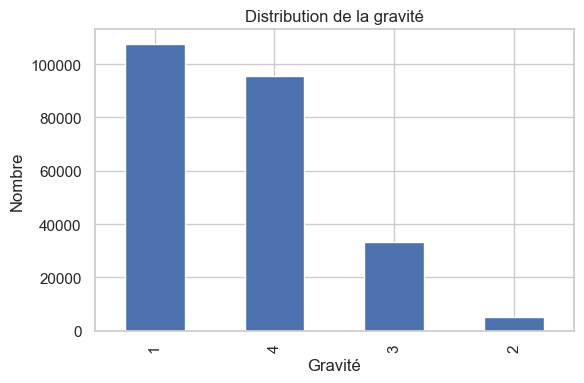

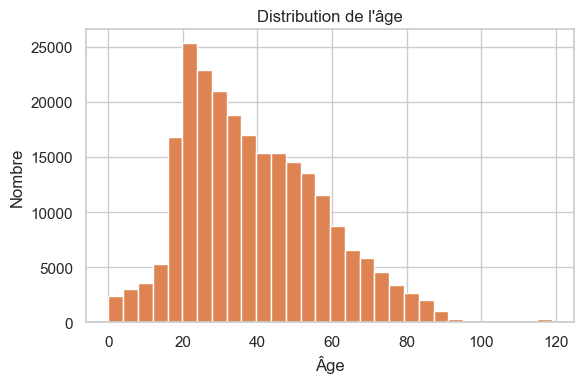

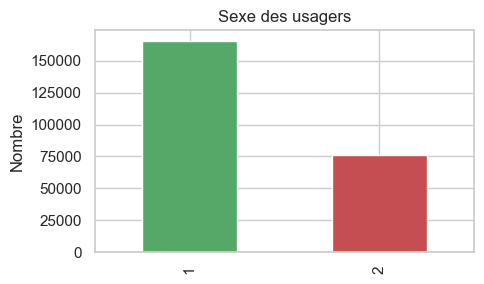

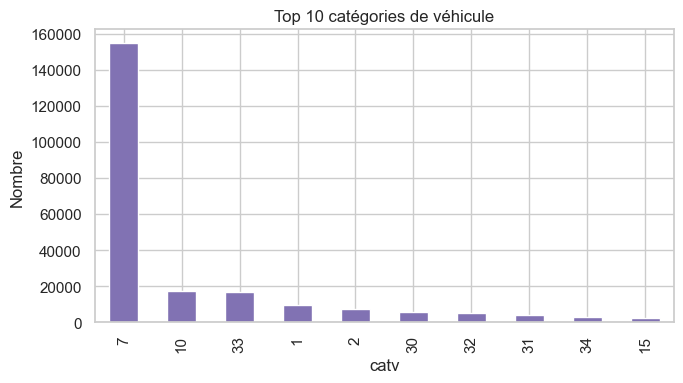

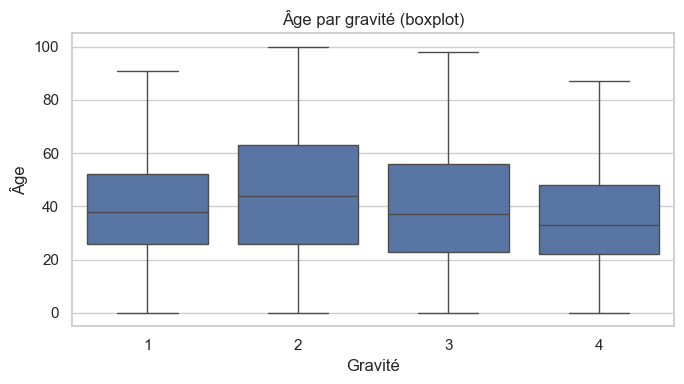

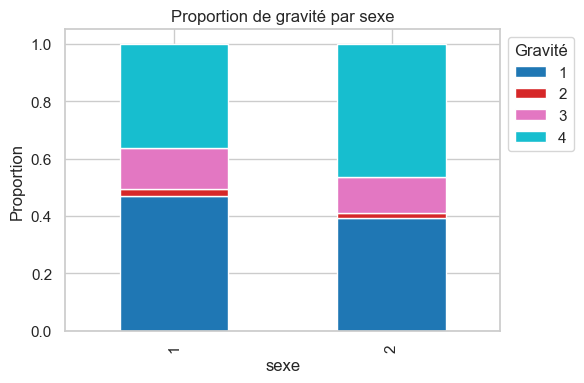

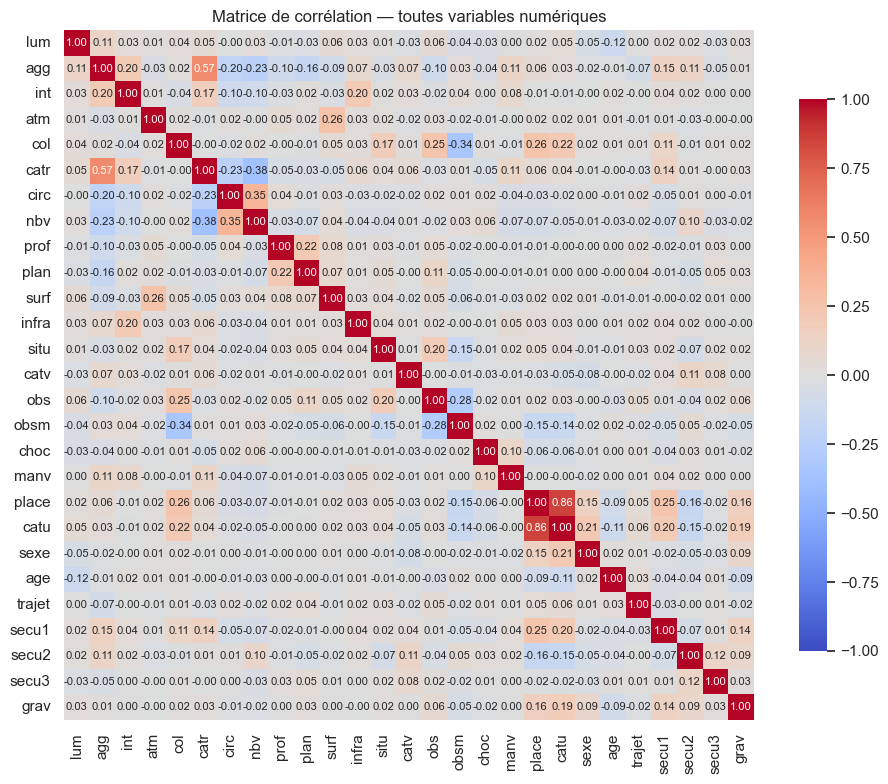

In [ ]:
# Statistiques descriptives
print("Statistiques descriptives pour les variables :")
print(df.describe())

# 1) Distribution de la gravité
plt.figure(figsize=(6,4))
df["grav"].value_counts().plot(kind="bar", color="C0")
plt.title("Distribution de la gravité")
plt.xlabel("Gravité")
plt.ylabel("Nombre")
plt.tight_layout()
plt.show()

# 2) Histogramme de l'âge
plt.figure(figsize=(6,4))
df["age"].dropna().hist(bins=30, color="C1")
plt.title("Distribution de l'âge")
plt.xlabel("Âge")
plt.ylabel("Nombre")
plt.tight_layout()
plt.show()

# 3) Sexe (barres)
plt.figure(figsize=(5,3))
df["sexe"].value_counts().plot(kind="bar", color=["C2","C3"])
plt.title("Sexe des usagers")
plt.xlabel("")
plt.ylabel("Nombre")
plt.tight_layout()
plt.show()

# 4) Catégorie de véhicule (top10)
plt.figure(figsize=(7,4))
df["catv"].value_counts().head(10).plot(kind="bar", color="C4")
plt.title("Top 10 catégories de véhicule")
plt.xlabel("catv")
plt.ylabel("Nombre")
plt.tight_layout()
plt.show()

# 5) Boxplot âge vs gravité
plt.figure(figsize=(7,4))
sns.boxplot(x="grav", y="age", data=df, showfliers=False)
plt.title("Âge par gravité (boxplot)")
plt.xlabel("Gravité")
plt.ylabel("Âge")
plt.tight_layout()
plt.show()

# 6) Crosstab proportionnelle sexe vs gravité
ct = pd.crosstab(df["sexe"], df["grav"], normalize="index")
ct.plot(kind="bar", stacked=True, figsize=(6,4), colormap="tab10")
plt.title("Proportion de gravité par sexe")
plt.ylabel("Proportion")
plt.legend(title="Gravité", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

# 7) Petite heatmap pour voir les corrélations
nums = df.select_dtypes(include=['number']).dropna()
corr = nums.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1,
square=True, cbar_kws={'shrink': 0.8}, annot_kws={'fontsize': 8})
plt.title('Matrice de corrélation — toutes variables numériques')
plt.tight_layout()
plt.show()

## Étape 4 : Préparation et séparation des données
Split train/test.

In [127]:
X = df.drop("grav", axis=1)
y = df["grav"]

num_features = ["age"]
cat_features = [col for col in X.columns if col not in num_features]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", "passthrough", cat_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Étape 5 : Construction d’un modèle de ML
Tester au moins deux modèles.

Validation croisée.

In [128]:
# Modèle 1 : Régression logistique
log_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Modèle 2 : Random Forest
rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Validation croisée (mis en commentaire pour éviter l'exécution longue)
#print("Validation croisée pour Logistic Regression :", cross_val_score(log_reg, X_train, y_train, cv=5, scoring='accuracy').mean())
#print("Validation croisée pour Random Forest :", cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy').mean())


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

## Étape 6 : Évaluation
Classification : Accuracy, F1-score, Matrice de confusion, ROC-AUC

In [129]:
for name, model in {
    "Logistic Regression": log_reg,
    "Random Forest": rf
}.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    print("\n", name)
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("F1-score :", f1_score(y_test, y_pred, average="macro"))
    print("ROC-AUC (OVR) :", roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))
    print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))


 Logistic Regression
Accuracy : 0.430565319879244
F1-score : 0.3355005071304108
ROC-AUC (OVR) : 0.6893654754224459
Matrice de confusion :
 [[11260  3632  1785  4845]
 [  151   619   172   121]
 [ 1419  2430  1290  1500]
 [ 6114  2915  2455  7654]]

 Random Forest
Accuracy : 0.7382862578057152
F1-score : 0.587598046652954
ROC-AUC (OVR) : 0.900699231640751
Matrice de confusion :
 [[18320    21   462  2719]
 [  155   186   435   287]
 [  978    71  3153  2437]
 [ 4023    31  1038 14046]]


## Étape 7 : Interprétation
### Feature importance

In [130]:
# Feature importance pour Random Forest
rf_model = rf.named_steps['model']
feature_names = num_features + cat_features
importances = rf_model.feature_importances_
for name, importance in zip(feature_names, importances):
    print(f"Feature: {name}, Importance: {importance:.4f}")

# Coefficients pour Logistic Regression (multi-classes)
log_reg_model = log_reg.named_steps['model']
coefficients = log_reg_model.coef_
for i, class_coef in enumerate(coefficients):
    print(f"Coefficients pour la classe {i+1} :")
    for name, coef in zip(feature_names, class_coef):
        print(f"  {name}: {coef:.4f}")

Feature: age, Importance: 0.1608
Feature: lum, Importance: 0.0331
Feature: agg, Importance: 0.0224
Feature: int, Importance: 0.0337
Feature: atm, Importance: 0.0271
Feature: col, Importance: 0.0534
Feature: catr, Importance: 0.0389
Feature: circ, Importance: 0.0262
Feature: nbv, Importance: 0.0374
Feature: prof, Importance: 0.0253
Feature: plan, Importance: 0.0246
Feature: surf, Importance: 0.0177
Feature: infra, Importance: 0.0227
Feature: situ, Importance: 0.0152
Feature: catv, Importance: 0.0537
Feature: obs, Importance: 0.0264
Feature: obsm, Importance: 0.0244
Feature: choc, Importance: 0.0558
Feature: manv, Importance: 0.0593
Feature: place, Importance: 0.0265
Feature: catu, Importance: 0.0153
Feature: sexe, Importance: 0.0203
Feature: trajet, Importance: 0.0522
Feature: secu1, Importance: 0.0750
Feature: secu2, Importance: 0.0485
Feature: secu3, Importance: 0.0041
Coefficients pour la classe 1 :
  age: -0.0649
  lum: -0.0565
  agg: 0.6888
  int: 0.0177
  atm: -0.0156
  col: 0.054

### Analyse des erreurs :
#### Principaux constats d'erreur :
Les deux modèles peinent à bien séparer les classes intermédiaires (notamment les classes 2 et 3) — beaucoup de confusions entre ces modalités.
La Random Forest réduit fortement certaines erreurs (meilleure AUC et F1), mais conserve des confusions pour les classes moins fréquentes.
Logistic Regression montre des biais structurels (faible accuracy et F1) : elle confond souvent les catégories et prédit massivement la classe 1 pour plusieurs vrais positifs d'autres classes.
#### Importance des variables (Random Forest) : 
Âge en tête (0.1608), puis secu1 (0.0750), manv (0.0593), choc (0.0558), catv (0.0537), col (0.0534), trajet (0.0522), secu2 (0.0485). Les autres variables ont importances plus faibles mais non négligeables.
#### Interprétation des coefficients (Logistic Regression) :
Classe 1 : agg très positif (0.6888) ; catu fortement négatif (-0.2789) ; sexe positif (0.0856).

Classe 2 : age fortement positif (0.2906) ; agg fortement négatif (-1.0227) ; sexe fortement négatif (-0.4592).

Classe 3 : coefficients généralement faibles ; agg négatif (-0.2659).

Classe 4 : agg positif (0.5999) ; sexe fortement positif (0.4165) ; catu positif (0.3210).
Ces signes montrent que agg, age, sexe, catu influencent différemment la probabilité d'appartenance aux classes.

### Recommandations :
Ajoutez des variables comme l'alcoolémie, la consommation de stupéfiants ou l'état de santé du conducteur (inapplicable car cela contredit le principe de la vie privée comme dit dans la présentation du jeu de données).

Équilibrez les classes 2 et 3 (SMOTE) avant d'entraîner pour améliorer la F1 sur ces classes.
Ciblez les actions de prévention sur les groupes identifiés (jeunes, zones urbaines) et promouvez l’usage des dispositifs de sécurité (secu1/secu2).